# Example 1: Cepstral Analysis of liquid water

This example shows the basic usage of *sportran* to compute the shear viscosity of a classical MD simulation of H$_2$O.

For reference: <a href="https://doi.org/10.1038/s41524-022-00830-7">Malosso et al., npj Comput Mater 8, 139 (2022).</a>


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
try:
    import sportran as st
except ImportError:
    from sys import path
    path.append('..')
    import sportran as st

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib notebook

## 1. Load trajectory

Read the heat current from a simple column-formatted file $\texttt{./data/h2o/h2o.dat}$.

In [3]:
!head -n 1 data/h2o/h2o.dat

Temp	s_xy	_xz	s_yz 


In [4]:
data = np.loadtxt('data/h2o/h2o.dat', skiprows = 1)

## 2. Stress Current

Define a **StressCurrent** from the trajectory, with the correct parameters. For the computation of the shear viscosity we need only the off diagonal elements of the stress tensor that are stored in **data[:,1:]** and the instantanous temperatures that are stored in **data[ : ,0]**.

In [5]:
DT_FS = 1                                  # time step [fs]
TEMPERATURE = np.mean(data[:,0])           # temperature [K] (983.173 K)
VOLUME = 1918.4149658                      # volume [A^3]
print(DT_FS, TEMPERATURE, VOLUME)

j = st.StressCurrent(data[:,1:], UNITS='real', DT_FS=DT_FS, TEMPERATURE=TEMPERATURE, VOLUME=VOLUME)

1 398.46784250010006 1918.4149658
Using single component code.


<IPython.core.display.Javascript object>


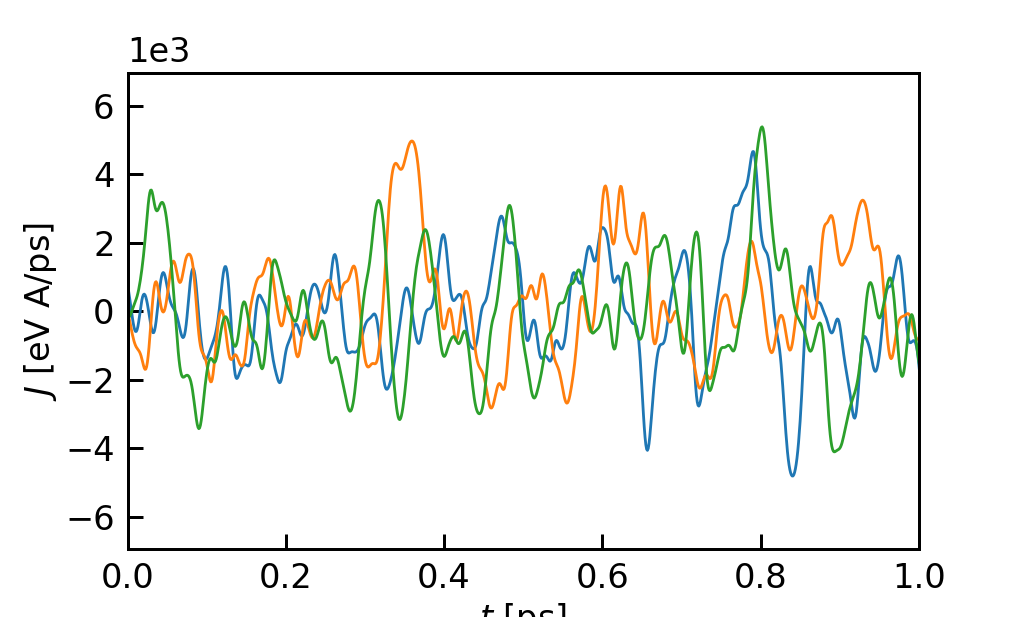

In [6]:
# trajectory
f = plt.figure()
ax = plt.plot(j.timeseries()/1000., j.traj);
plt.xlim([0, 1.0])
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

Compute the **Power Spectral Density** ($\rm PSD$) and filter it for visualization.

<IPython.core.display.Javascript object>


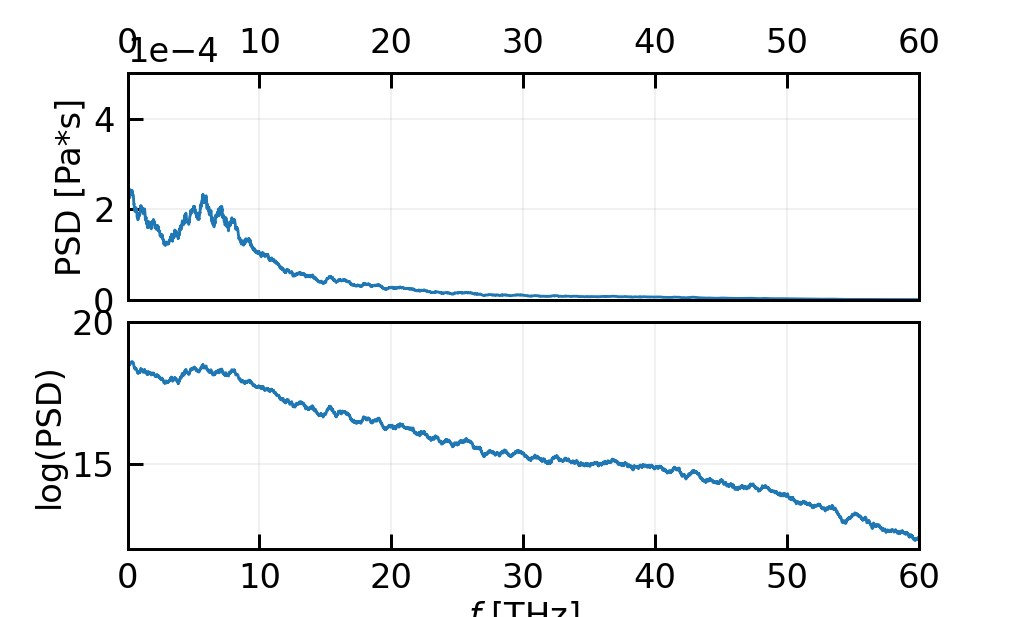

500.0


In [7]:
# Periodogram with given filtering window width
ax = j.plot_periodogram(PSD_FILTER_W=0.5, kappa_units=True)
print(j.Nyquist_f_THz)
plt.xlim([0, 60])
ax[0].set_ylim([0, 0.5e-3]);
ax[1].set_ylim([12, 20]);

## 3. Resampling

If the Nyquist frequency is very high (*i.e.* the sampling time is very small), such that the log-spectrum goes to low values, you may want *resample* your time series, in order to reduce the maximum frequency to $f^*$.
Before performing that operation, the time series is automatically filtered to reduce the amount of aliasing introduced. Ideally you do not want to go too low in $f^*$, because the statistical error may increase. In an intermediate region the results should not change. 

To perform resampling you can choose the resampling frequency $f^*$ (`fstar_THz`) or the resampling step (`TSKIP`). If you choose $f^*$, the code will try to find the closest value allowed.
The resulting $\rm PSD$ can be visualized to ensure that the low-frequency region was not affected by this operations

Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      25.00000 THz
 Sampling time         TSKIP =            20 steps
                             =        20.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2501
 PSD      @cutoff  (pre-filter&sample) ~ 8472561.64839
                  (post-filter&sample) ~ 7406104.37649
 log(PSD) @cutoff  (pre-filter&sample) ~     15.68271
                  (post-filter&sample) ~     15.63555
 min(PSD)          (pre-filter&sample) =      0.07246
 min(PSD)         (post-filter&sample) = 299500.00551
 % of original PSD Power f<f* (pre-filter&sample)  = 92.375 %
-----------------------------------------------------



<IPython.core.display.Javascript object>


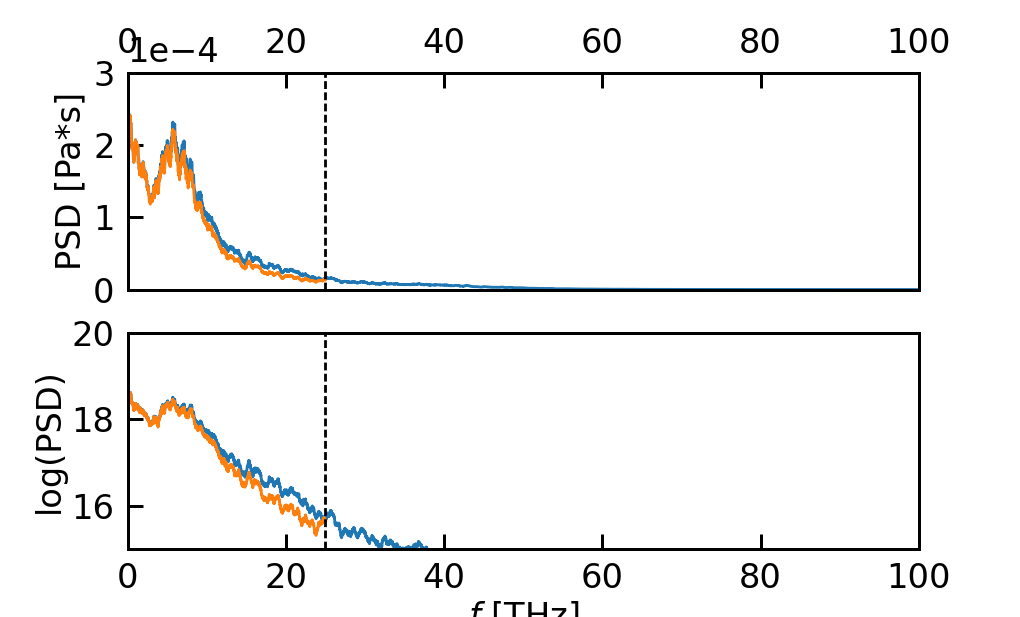

In [28]:
FSTAR_THZ = 25
jf, ax = j.resample(fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 100])
ax[0].set_ylim([0, 0.3e-3]);
ax[1].set_ylim([15, 20]);

<IPython.core.display.Javascript object>


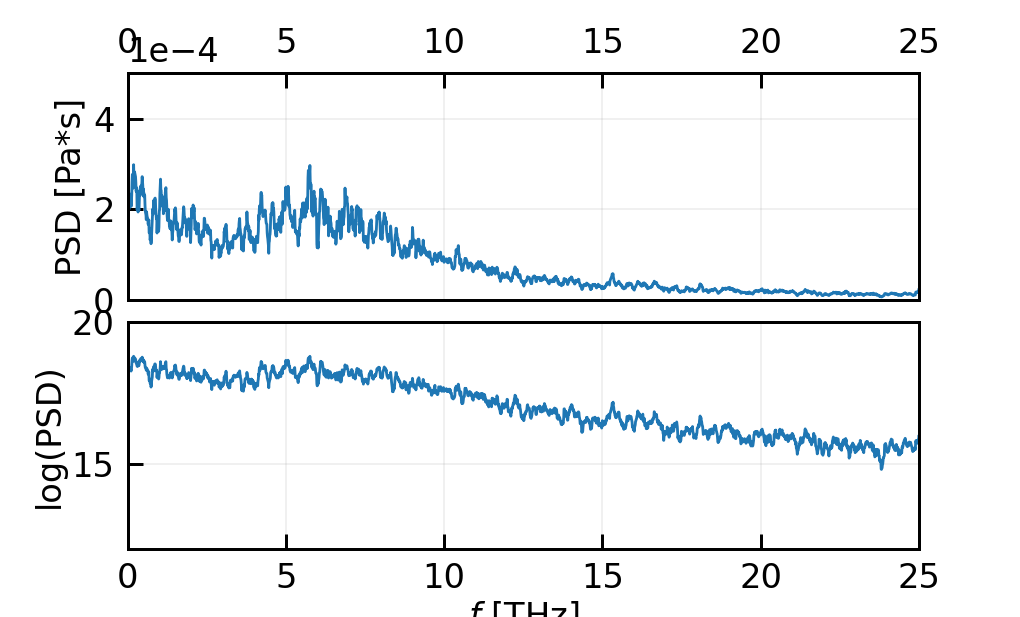

In [29]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[0].set_ylim([0, 0.5e-3]);
ax[1].set_ylim([12, 20]);

## 4. Cepstral Analysis

Perform Cepstral Analysis. The code will perform the following operations:
 1. compute the parameters describing the theoretical distribution of the $\rm PSD$
 2. compute the Cepstral coefficients by Fourier transforming the $\log(\rm{PSD})$
 3. apply the Akaike Information Criterion, to choose the number of cepstral coefficients $P^*$
 4. return the resulting transport coefficient (viscosity) $\eta$

In [30]:
jf.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 10  (auto, AIC_Kmin = 10, corr_factor =  1.0)
  L_0*   =          18.297017 +/-   0.057597
  S_0*   =   127801909.034038 +/- 7361041.782368
-----------------------------------------------------
  kappa* =           0.000229 +/-   0.000013  Pa*s
-----------------------------------------------------



c_k =  [ 1.72206042e+01  6.94703788e-01 -4.33846235e-02 ...  2.22448841e-03
  1.09731963e-03  7.87480033e-03]


<IPython.core.display.Javascript object>


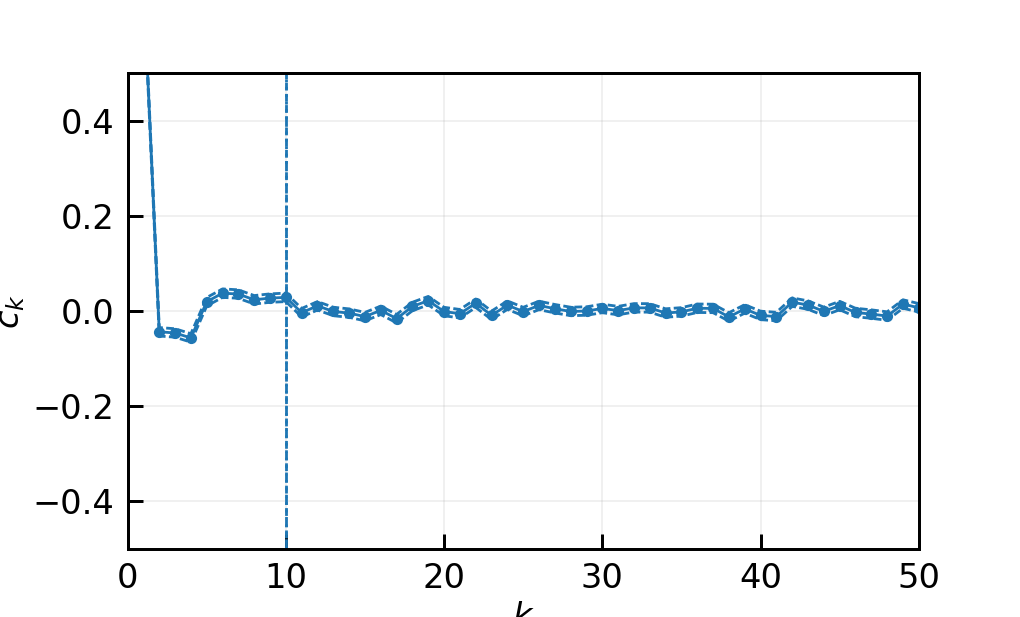

In [31]:
# Cepstral Coefficients
print('c_k = ', jf.cepf.logpsdK)

ax = jf.plot_ck()
ax.set_xlim([0, 50])
ax.set_ylim([-0.5, 0.5])
ax.grid();

<IPython.core.display.Javascript object>


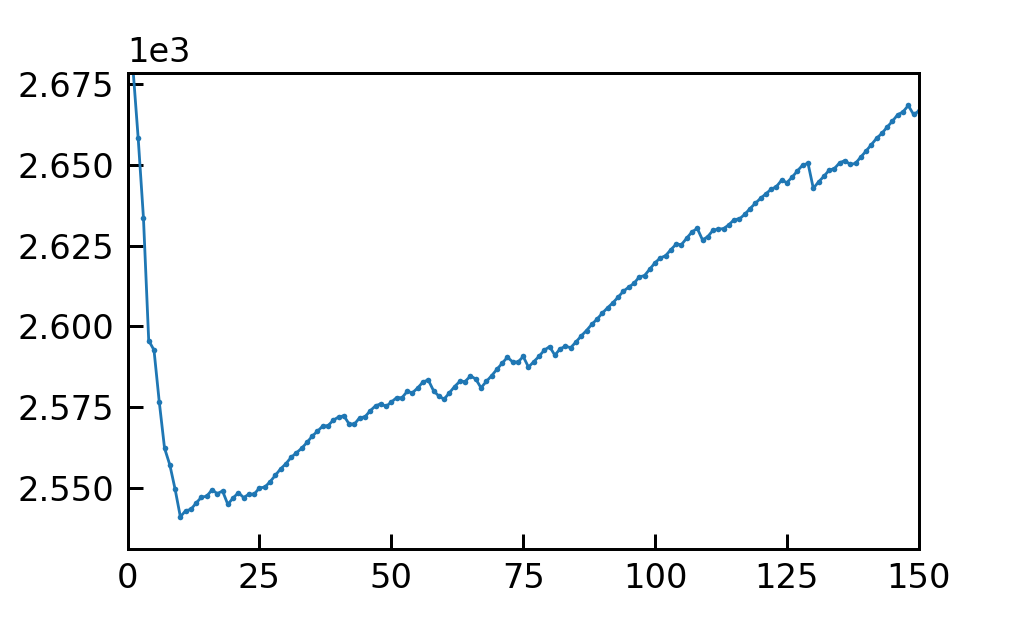

K of AIC_min = 10
AIC_min = 2540.981427


In [32]:
# AIC function
f = plt.figure()
plt.plot(jf.cepf.aic, '.-', c=c[0])
plt.xlim([0, 150])
plt.ylim([min(jf.cepf.aic[:150]) - 10, max(jf.cepf.aic[50:150]) + 10]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

Plot the viscosity $\eta$ as a function of the cutoff $P^*$

<IPython.core.display.Javascript object>


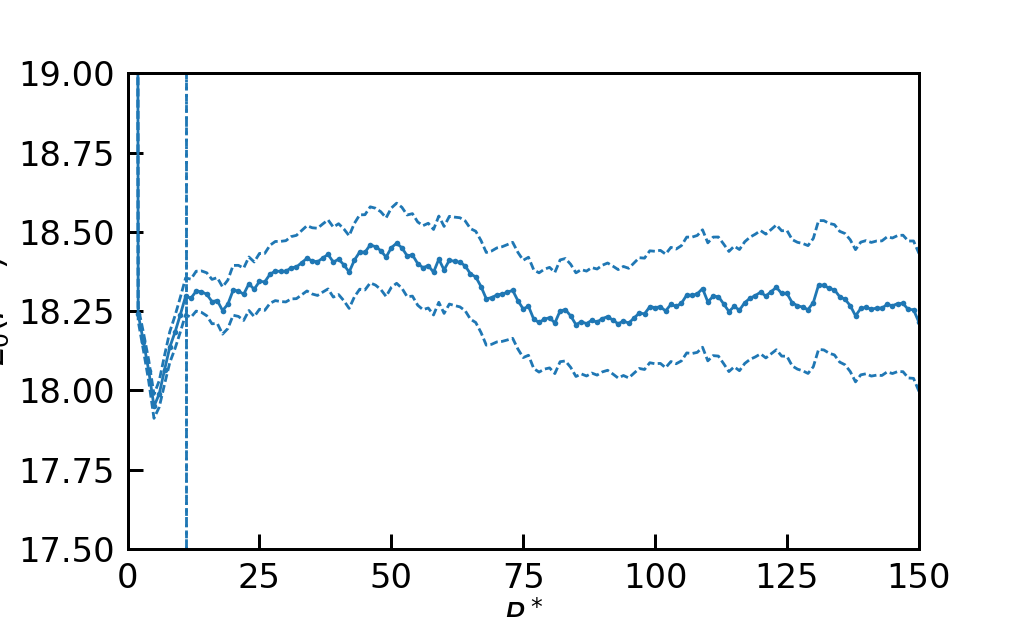

K of AIC_min = 10
AIC_min = 2540.981427


In [33]:
# L_0 as a function of cutoff K
ax = jf.plot_L0_Pstar()
ax.set_xlim([0, 150])
ax.set_ylim([17.5, 19]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

<IPython.core.display.Javascript object>


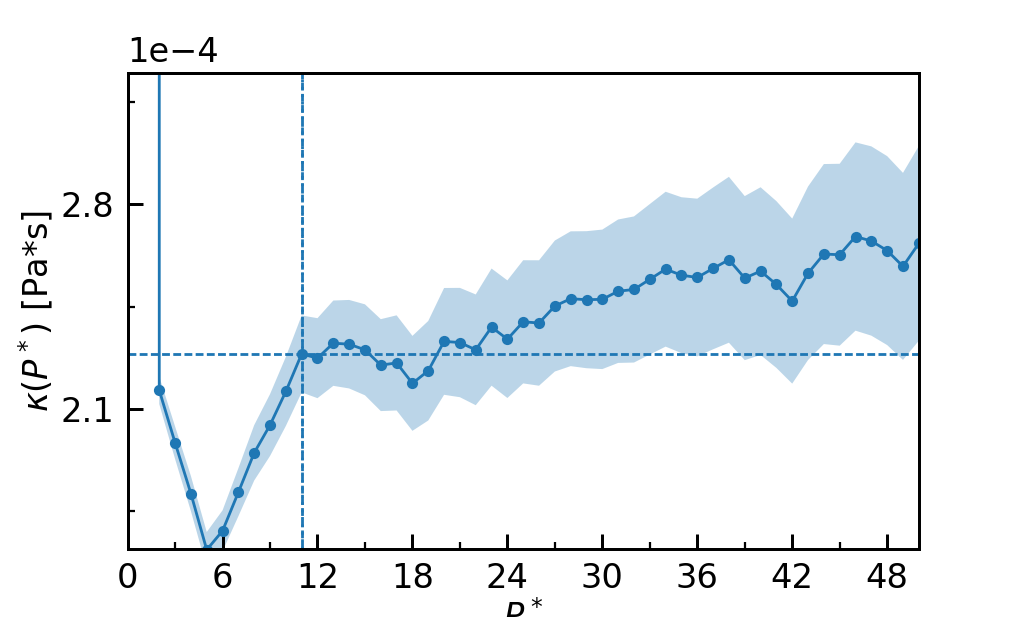

K of AIC_min = 10
AIC_min = 2540.981427


In [34]:
# kappa as a function of cutoff K
ax = jf.plot_kappa_Pstar()
ax.set_xlim([0, 50])
#ax.set_ylim([0, 5.0]);

print('K of AIC_min = {:d}'.format(jf.cepf.aic_Kmin))
print('AIC_min = {:f}'.format(jf.cepf.aic_min))

Print the results :)

In [35]:
results = jf.cepstral_log
print(results)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 10  (auto, AIC_Kmin = 10, corr_factor =  1.0)
  L_0*   =          18.297017 +/-   0.057597
  S_0*   =   127801909.034038 +/- 7361041.782368
-----------------------------------------------------
  kappa* =           0.000229 +/-   0.000013  Pa*s
-----------------------------------------------------



You can now visualize the filtered PSD...

<IPython.core.display.Javascript object>


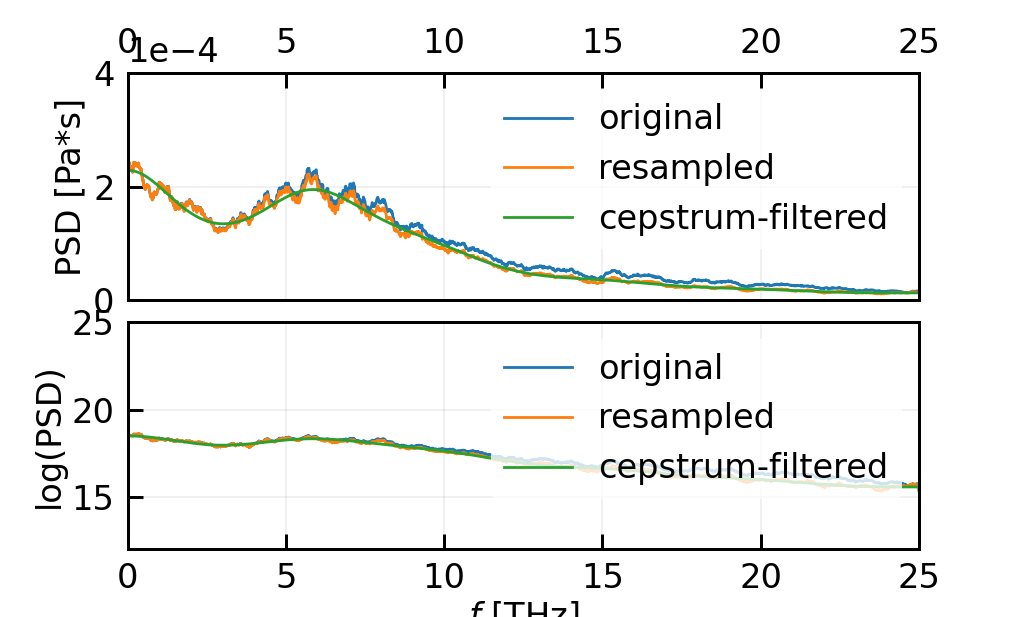

In [40]:
# filtered log-PSD
ax = j.plot_periodogram(0.5, kappa_units=True)
ax = jf.plot_periodogram(0.5, axes=ax, kappa_units=True)
ax = jf.plot_cepstral_spectrum(axes=ax, kappa_units=True)
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 25.])
ax[0].set_ylim([0,4e-4])
ax[1].set_ylim([12,25])
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);